# Customer Churn Pridction - Ulwetel

## Gajendra Muley - 23PGAI0048

### Final Output
We get 90% accuracy with our model. In further scope, I will try to improve this accuracy by fine tuning the parameters for gridsearch and by using more advanced models.

### Reference 
https://towardsdatascience.com/churn-prediction-with-machine-learning-ca955d52bd8c


### Let's get started.
Let's begin by importing the required libraries and doing a basic analysis of the data. I have used derived columns in the dataset. Hence the number of columns is more than that of the original dataset.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Dataset
df = pd.read_csv("Dataset.csv")
df.shape


(1000, 50)

In [8]:
df.head()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,total_call_count,total_sum_duration,...,avg_days_bw_rchg_and_expiry,stddev_days_bw_rchg_and_expiry,price_per_day,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,activation_code_wrt_churn,current_code_wrt_churn,churn
0,10000,individual,4,0,31,333,31.980873,548.719448,364,580.700321,...,-1.113238,2.801930,3.333333,1.5,6.864912,10K_to_20K,-3.221785,2,2.0,0
1,10001,individual,6,0,8,42,9.577651,43.988952,50,53.566603,...,-2.032090,1.600223,5.550000,3.0,3.985185,10K_to_20K,-4.916200,2,3.0,0
2,10002,individual,8,1,13,0,15.368591,0.000000,13,15.368591,...,-2.350133,0.782016,4.571429,1.0,15.338890,20K_to_30K,4.455835,2,2.0,0
3,10003,individual,7,0,20,38,21.091508,52.044282,58,73.135790,...,2.366904,1.255292,4.284286,4.0,9.241717,less_10K,0.180850,1,2.0,0
4,10004,individual,3,1,22,29,25.592874,41.290402,51,66.883276,...,2.121814,3.132883,4.109589,3.0,12.263939,10K_to_20K,4.690059,1,3.0,0


Checking for missing values. This will also return the list of values for exploration. 

In [9]:
null_counts = df.isnull().sum()
print(null_counts)

customer_id                            0
ownership                              0
activation_plan_code                   0
mnp_flag                               0
calls_incoming_cnt                     0
calls_outgoing_cnt                     0
calls_incoming_duration                0
calls_outgoing_duration                0
total_call_count                       0
total_sum_duration                     0
tot_usage_mb                           0
upload_usage_mb                        0
download_usage_mb                      0
days_since_latch                       0
cnt_open_qrc                           0
avg_days_to_close                     26
cnt_call_drops                         0
pcnt_dropped_calls                     0
rsrp_voice_pcnt_poor_duration          0
rsrp_data_pcnt_poor_duration           0
mean_cqi_voice_pcnt_poor_duration      0
sinr_voice_pcnt_poor_duration          0
sinr_data_pcnt_poor_duration           0
age_on_network                         0
cnt_connections 

Found two columns with missing values. Let's use median imputation to for missing value treatment as the data is right skwed.

In [10]:
distribution = df['avg_days_to_close'].value_counts(normalize=True)
print(distribution)

9.0     0.117043
5.0     0.110883
6.0     0.099589
14.0    0.094456
11.0    0.088296
8.0     0.087269
12.0    0.086242
7.0     0.085216
13.0    0.081109
10.0    0.077002
4.0     0.072895
Name: avg_days_to_close, dtype: float64


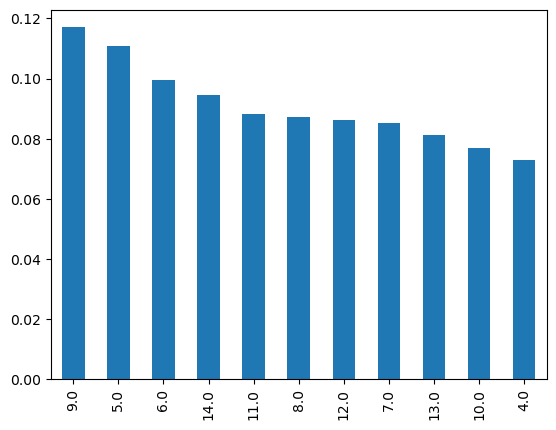

In [11]:
distribution.plot(kind='bar')
plt.show()

If the length of the bars in a distribution plot is reducing as you go further on the x axis, it means that the values are skewed to the left. This means that there are fewer high values and more low values.

For such a distribution, median imputation might be a good choice. Median imputation replaces missing values with the median of the non-missing values in the column. Since the median is less sensitive to outliers than the mean, it can be a more robust summary statistic for a skewed distribution.

However, it's worth noting that no imputation method is perfect, and it's always a good idea to compare the results of multiple imputation methods and choose the one that gives the most reasonable estimates.
(Courtesy Chatgpt!)

In [12]:
# Compute the median of the column
median = df["avg_days_to_close"].median()

# Replace missing values with the median
df["avg_days_to_close"].fillna(median, inplace=True)

I have added some derived data to the dataset. Let's also treat the missing values in the derived column. Lets start by visualizing it.

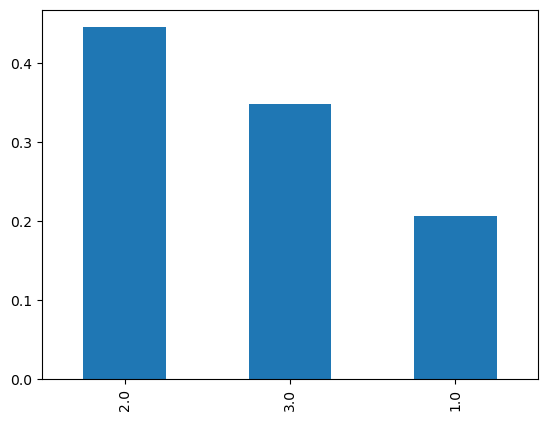

In [13]:
distribution = df['current_code_wrt_churn'].value_counts(normalize=True)
distribution.plot(kind='bar')
plt.show()

In [14]:
# Compute the median of the column
median = df["current_code_wrt_churn"].median()

# Replace missing values with the median
df["current_code_wrt_churn"].fillna(median, inplace=True)

In [15]:
#Checking if missing values are treated.
df.isna().sum().sum()

0

In [16]:
#Inspect the target variable
df.churn.value_counts()

0    744
1    256
Name: churn, dtype: int64

The target variable has imbalanced class distribution. The number of churing customers is 3x the retained customers. We will use upsampling and downsampling to get a better model. We can start by exploring different features to decide further course of action. Let's begin with binary features.

#### Acquisition related featues
activation_plan_code, ownership,  mnp_flag

In [17]:
#Get a list of binary fetures
columns = df.columns
binary_cols = []
for col in columns:
    if df[col].value_counts().shape[0] == 2:
        binary_cols.append(col)
binary_cols

['ownership', 'mnp_flag', 'churn']

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='churn', ylabel='count'>

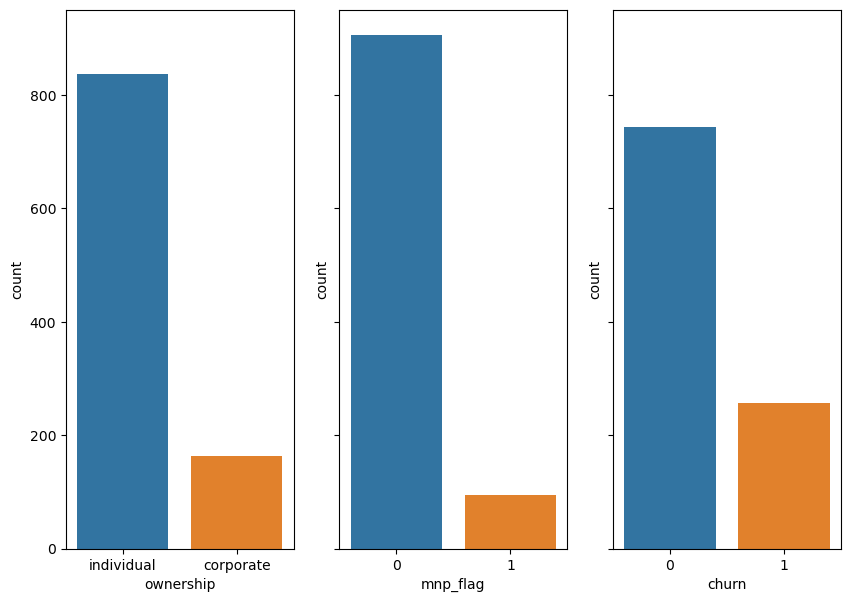

In [18]:
# Create the plot
fig, axes = plt.subplots(1, 3, figsize=(10, 7), sharey=True)
# sns.countplot("ownership", data=df, ax=axes[0,0])
# sns.countplot("mnp_flag", data=df, ax=axes[0,1])
# sns.countplot("mnp_flag", data=df, ax=axes[0,2])
sns.countplot("ownership", data=df, ax=axes[0])
sns.countplot("mnp_flag", data=df, ax=axes[1])
sns.countplot("churn", data=df)

There is high imbalance in the individual vs corporate and mnp_flag columns. 
Let's see how the target variable churn chages with respect to these features. 


In [19]:
#Lets see if churn rate is different for individual vs corporate. 
df[['ownership','churn']].groupby(['ownership']).mean()

,churn
ownership,
corporate,0.245399
individual,0.258065


In [20]:
#Lets see if churn rate is different for ported vs non ported customers. 
df[['mnp_flag','churn']].groupby(['mnp_flag']).mean()

,churn
mnp_flag,
0,0.253039
1,0.284211


The churn rate for either of the categories from the above features is similar. We can ignore these features. Lets move on to explore other categorical features. We will explore the continous features later.

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='activation_plan_code', ylabel='count'>

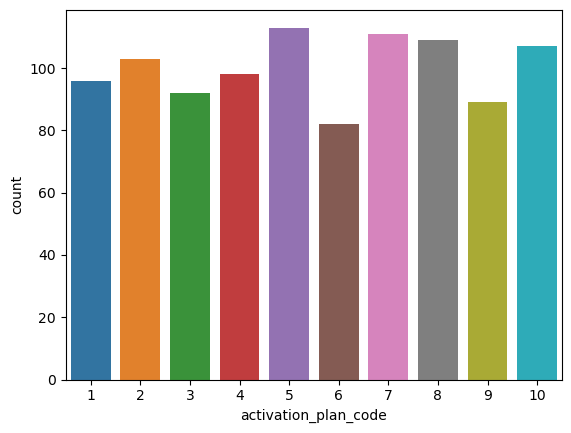

In [21]:
# Create the plot
sns.countplot("activation_plan_code", data=df)

In [22]:
df[['activation_plan_code','churn']].groupby(['activation_plan_code']).mean()

,churn
activation_plan_code,
1,0.229167
2,0.310680
3,0.130435
4,0.214286
5,0.150442
6,0.231707
7,0.180180
8,0.192661
9,0.808989


We can see that the 2nd and 9th activation plans results in high churn. Churn for 3rd and 5th plan is the lowest.Since we do can not further inspect the reason for this behaviour due to lack of data, we will use this feature in our model.

Now lets see how the engagement features affect churn.

Lets convert this into an orinal variable names activation_plan_wrt_churn The conversion is done is excel and new column will be added. 

If the value of activation_plan_code is 3, 5, 7, 10 then value of activation_code_wrt_churn shoud be 1.

If the value of activation_plan_code is 8, 1, 4, 6 then value of activation_code_wrt_churn shoud be 2.

If the value of activation_plan_code is 2, 1, 9 then value of activation_code_wrt_churn shoud be 3.

In [23]:
df[['activation_code_wrt_churn','churn']].groupby(['activation_code_wrt_churn']).mean()

,churn
activation_code_wrt_churn,
1,0.163121
2,0.215584
3,0.541667


We can see the significant difference in values. This will also help our model to compute faster.

let's move on to the next set of features.
#### Engagement related features.
calls_incoming_cnt	calls_outgoing_cnt	calls_incoming_duration	calls_outgoing_duration	total_call_count	total_sum_duration
tot_usage_mb	upload_usage_mb	download_usage_mb 
days_since_latch

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

<AxesSubplot:xlabel='days_since_latch', ylabel='Density'>

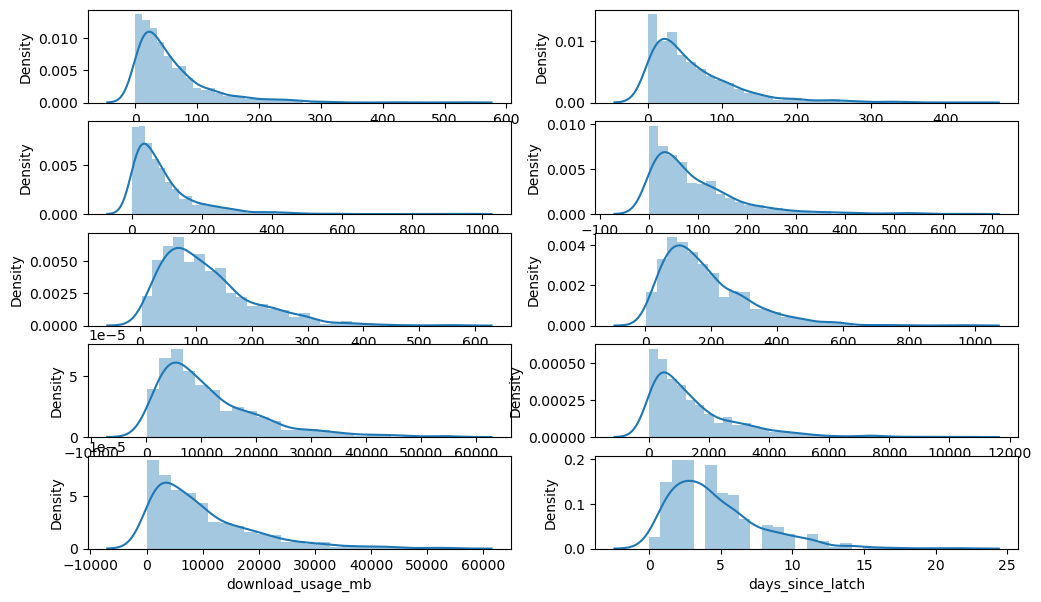

In [24]:
fig, axes = plt.subplots(5,2, figsize=(12, 7))
sns.distplot(df["calls_incoming_cnt"],  ax=axes[0,0])
sns.distplot(df["calls_outgoing_cnt"], ax=axes[0,1])

sns.distplot(df["calls_incoming_duration"],  ax=axes[1,0])
sns.distplot(df["calls_outgoing_duration"], ax=axes[1,1])

sns.distplot(df["total_call_count"],  ax=axes[2,0])
sns.distplot(df["total_sum_duration"], ax=axes[2,1])

sns.distplot(df["tot_usage_mb"],  ax=axes[3,0])
sns.distplot(df["upload_usage_mb"], ax=axes[3,1])

sns.distplot(df["download_usage_mb"],  ax=axes[4,0])
sns.distplot(df["days_since_latch"], ax=axes[4,1])



In [25]:
# calls_incoming_cnt, calls_outgoing_cnt, calls_incoming_duration, calls_outgoing_duration share a similar distribution. Let's see how they affect churn.

df[['calls_incoming_cnt', 'calls_outgoing_cnt', 'calls_incoming_duration', 'calls_outgoing_duration', 'churn']].groupby(['churn']).mean()


,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration
churn,,,,
0,61.358871,60.259409,92.589817,91.368976
1,52.527344,62.328125,79.800261,93.486177


We can safely drop the features calls_outgoing_cnt and calls_outgoing_duration from our model. These features do not affect churn greatly and have a similar distribution to the other two features.

In [26]:
# Lets inspect churn with respect to total_call_count, total_sum_duration, tot_usage_mb, upload_usage_mb, download_usage_mb, and days_since_latch

df[['total_call_count', 'total_sum_duration', 'tot_usage_mb', 'download_usage_mb', 'days_since_latch', 'churn']].groupby(['churn']).mean()

,total_call_count,total_sum_duration,tot_usage_mb,download_usage_mb,days_since_latch
churn,,,,,
0,121.618280,183.958793,12572.110559,11042.262968,4.653226
1,114.855469,173.286438,8362.595099,6976.886420,4.390625


Except days_since_latch, we will be keeping all the other features from above. 

Finally, we will use calls_incoming_cnt, calls_incoming_duration, total_call_count, total_sum_duration, tot_usage_mb, upload_usage_mb, and download_usage_mb from the *Engagement* type columns.


Let's move to explicit and implicit experience features.

#### Explicit experience related features
cnt_open_qrc	avg_days_to_close	


#### Implicit Experience related features
cnt_call_drops	pcnt_dropped_calls	rsrp_voice_pcnt_poor_duration	rsrp_data_pcnt_poor_duration	mean_cqi_voice_pcnt_poor_duration	sinr_voice_pcnt_poor_duration	sinr_data_pcnt_poor_duration



C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_days_to_close', ylabel='Density'>

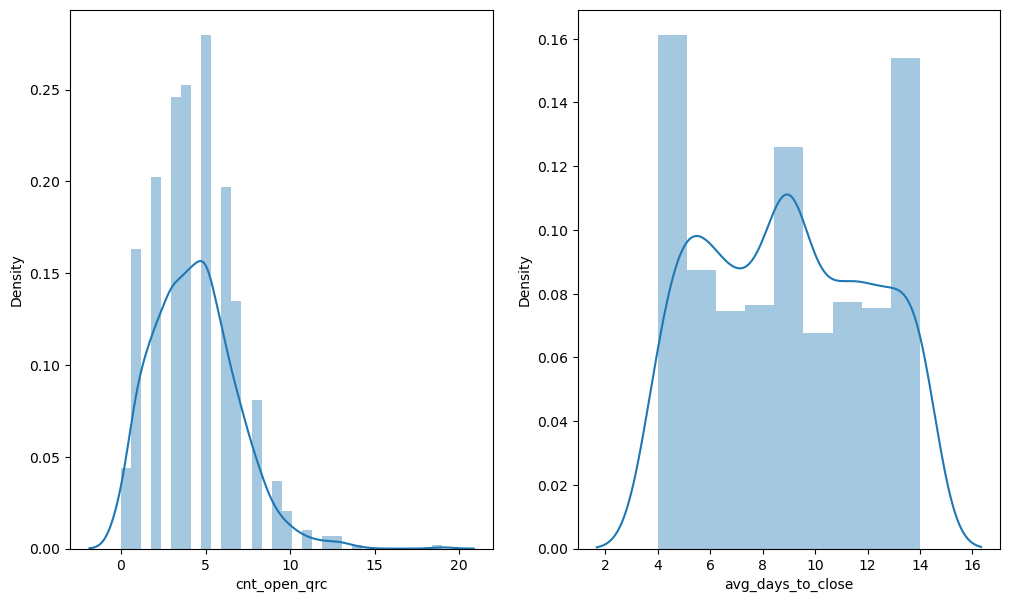

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12, 7))
sns.distplot(df["cnt_open_qrc"], ax=axes[0])
sns.distplot(df["avg_days_to_close"], ax=axes[1])

In [28]:
df[[ 'cnt_open_qrc', 'avg_days_to_close', 'churn']].groupby(['churn']).mean()

,cnt_open_qrc,avg_days_to_close
churn,,
0,4.243280,8.930108
1,4.730469,8.992188


Both these features do not impact churn greatly. We will not include them in our model.

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

<AxesSubplot:xlabel='sinr_data_pcnt_poor_duration', ylabel='Density'>

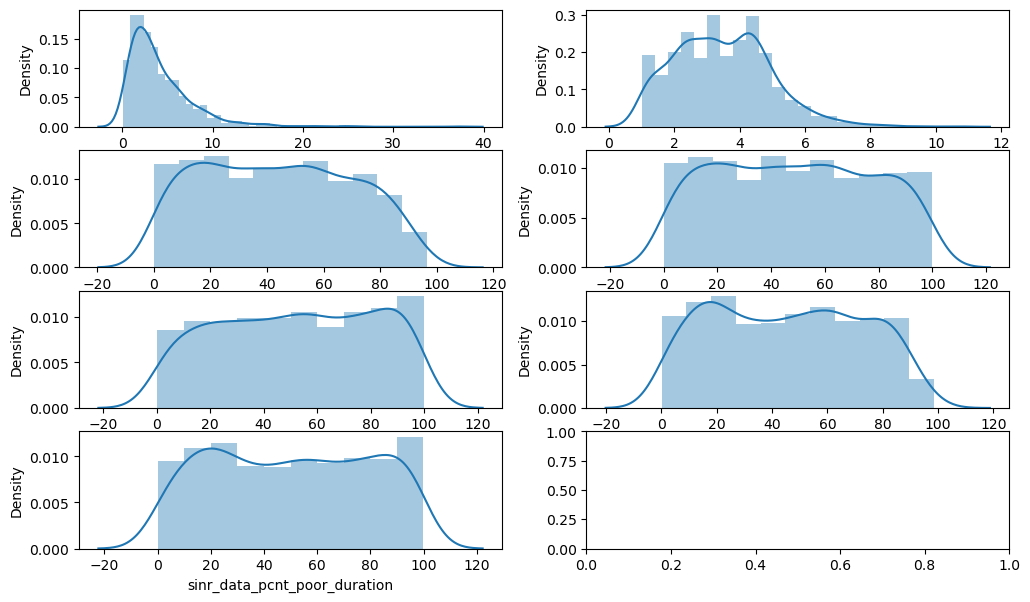

In [29]:
#Now lets explore implicit experience.

fig, axes = plt.subplots(4,2, figsize=(12, 7))
sns.distplot(df["cnt_call_drops"],  ax=axes[0,0])
sns.distplot(df["pcnt_dropped_calls"], ax=axes[0,1])

sns.distplot(df["rsrp_voice_pcnt_poor_duration"],  ax=axes[1,0])
sns.distplot(df["rsrp_data_pcnt_poor_duration"], ax=axes[1,1])

sns.distplot(df["mean_cqi_voice_pcnt_poor_duration"],  ax=axes[2,0])
sns.distplot(df["sinr_voice_pcnt_poor_duration"], ax=axes[2,1])

sns.distplot(df["sinr_data_pcnt_poor_duration"],  ax=axes[3,0])

In [30]:
df[['cnt_call_drops', 'pcnt_dropped_calls', 'rsrp_voice_pcnt_poor_duration', 'rsrp_data_pcnt_poor_duration', 'mean_cqi_voice_pcnt_poor_duration', 'sinr_voice_pcnt_poor_duration', 'sinr_data_pcnt_poor_duration', 'churn']].groupby(['churn']).mean()

,cnt_call_drops,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration
churn,,,,,,,
0,4.169790,3.442367,42.165443,46.885803,50.897739,45.925858,51.021875
1,4.062199,3.570944,48.000503,53.630069,56.619663,43.780156,48.614976


We keep the features rsrp_voice_pcnt_poor_duration, rsrp_data_pcnt_poor_duration, mean_cqi_voice_pcnt_poor_duration

We drop the features cnt_call_drops, pcnt_dropped_calls, sinr_voice_pcnt_poor_duration, sinr_data_pcnt_poor_duration

Now lets check the loyalty features
#### Loyalty related features
age_on_network	cnt_connections, cnt_recharges_made	

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

<AxesSubplot:xlabel='cnt_recharges_made', ylabel='Density'>

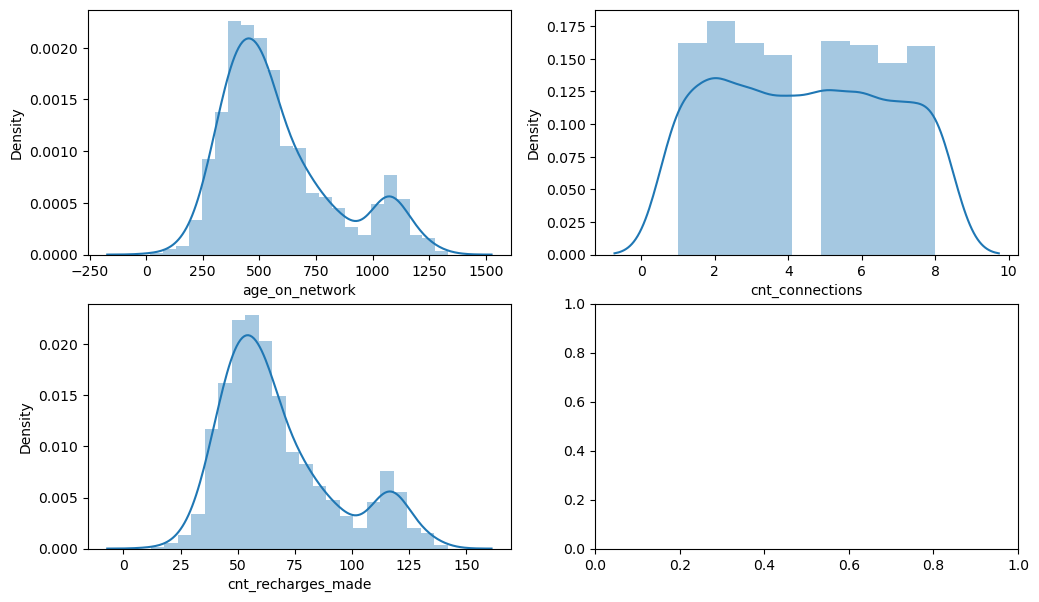

In [31]:

fig, axes = plt.subplots(2,2, figsize=(12, 7))
sns.distplot(df["age_on_network"],  ax=axes[0,0])
sns.distplot(df["cnt_connections"], ax=axes[0,1])
sns.distplot(df["cnt_recharges_made"], ax=axes[1,0])

In [32]:
df[[ 'age_on_network', 'cnt_connections', 'cnt_recharges_made', 'churn']].groupby(['churn']).mean()

,age_on_network,cnt_connections,cnt_recharges_made
churn,,,
0,587.438172,4.720430,67.900538
1,570.222656,3.597656,66.179688


Only age_on_network seems relavant. We will drop the other columns.

Moving on to payments

#### Payments related features
current_plan_code   cnt_recharges_made  total_payment_made	  cnt_main_plans_taken	total_main_plans_mrp	cnt_addon_plans_taken	total_addon_plans_mrp
cnt_rchg_offline	cnt_rchg_online	cnt_rchg_on_or_before_expiry	cnt_rchg_after_expiry 
current_active_plan_mrp	current_active_plan_validity	last_cycle_plan_mrp	last_cycle_plan_validity price_per_day	
avg_days_bw_rchg_and_expiry	stddev_days_bw_rchg_and_expiry    price_per_day  gb_per_day_quota  	pcnt_quota_used

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='current_plan_code', ylabel='count'>

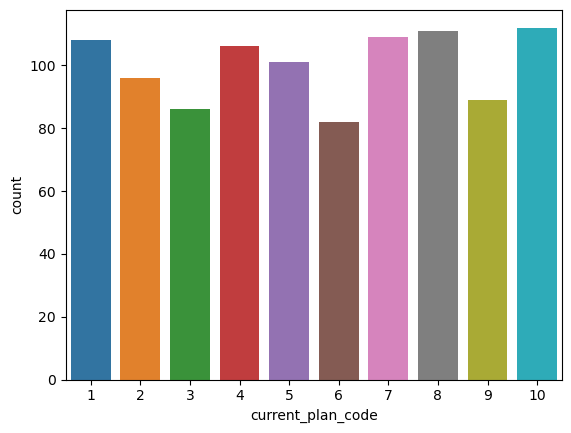

In [33]:

# Create the plot for categorical value of plan code
sns.countplot("current_plan_code", data=df)

In [34]:

df[['current_plan_code','churn']].groupby(['current_plan_code']).mean()

,churn
current_plan_code,
1,0.240741
2,0.250000
3,0.244186
4,0.245283
5,0.207921
6,0.158537
7,0.302752
8,0.315315
9,0.258427


Lets create a new column current_code_wrt_churn
if the value of current_plan_code is 6, 5 then value of current_code_wrt_churn shoud be 1. 
if the value of current_plan_code is 3, 1, 4, 2 then value of current_code_wrt_churn shoud be 2. 
if the value of current_plan_code is 7, 9, 10 then value of current_code_wrt_churn shoud be 3.

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

<AxesSubplot:xlabel='total_addon_plans_mrp', ylabel='Density'>

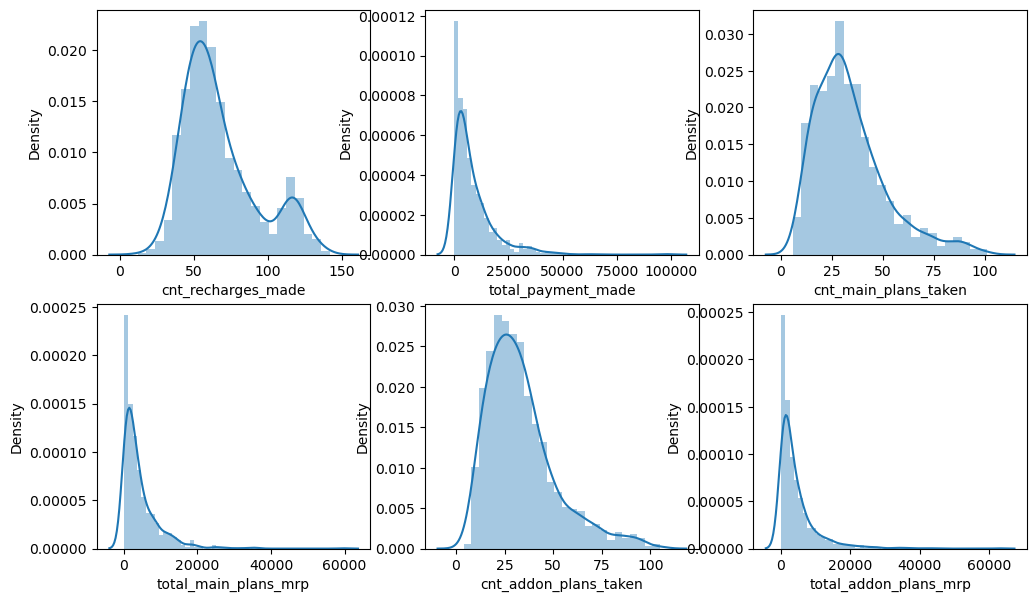

In [35]:
fig, axes = plt.subplots(2,3, figsize=(12, 7))
sns.distplot(df["cnt_recharges_made"],  ax=axes[0,0])
sns.distplot(df["total_payment_made"], ax=axes[0,1])
sns.distplot(df["cnt_main_plans_taken"], ax=axes[0,2])
sns.distplot(df["total_main_plans_mrp"],  ax=axes[1,0])
sns.distplot(df["cnt_addon_plans_taken"], ax=axes[1,1])
sns.distplot(df["total_addon_plans_mrp"], ax=axes[1,2])


In [36]:
df[['cnt_recharges_made', 'total_payment_made', 'cnt_main_plans_taken', 'total_main_plans_mrp', 'cnt_addon_plans_taken', 'total_addon_plans_mrp', 'churn']].groupby(['churn']).mean()


,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp
churn,,,,,,
0,67.900538,8788.167042,33.936828,4283.297565,33.963710,4504.869477
1,66.179688,8647.438273,33.843750,4413.749892,32.335938,4233.688381


Features selected: total_payment_made, total_main_plans_mrp, total_addon_plans_mrp


Features dropped: cnt_recharges_made, cnt_main_plans_taken, cnt_addon_plans_taken

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cnt_rchg_online', ylabel='Density'>

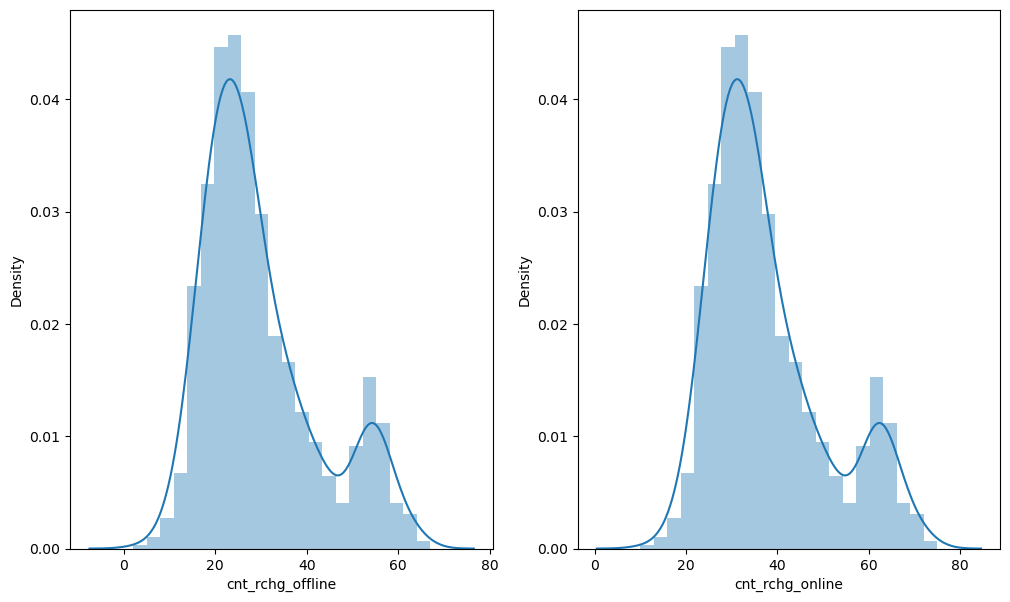

In [37]:

fig, axes = plt.subplots(1,2, figsize=(12, 7))
sns.distplot(df["cnt_rchg_offline"], ax=axes[0])
sns.distplot(df["cnt_rchg_online"], ax=axes[1])

In [38]:
df[[ 'cnt_rchg_offline', 'cnt_rchg_online', 'churn']].groupby(['churn']).mean()

,cnt_rchg_offline,cnt_rchg_online
churn,,
0,29.950269,37.950269
1,29.089844,37.089844


Both the above features dropped.

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

<AxesSubplot:xlabel='pcnt_quota_used', ylabel='Density'>

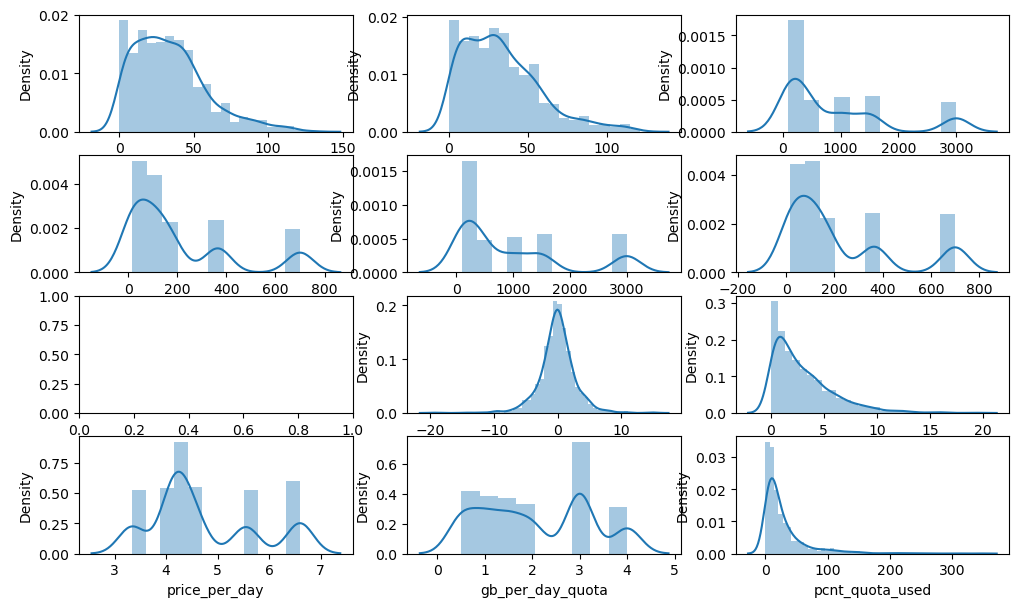

In [39]:

fig, axes = plt.subplots(4,3, figsize=(12, 7))
sns.distplot(df["cnt_rchg_on_or_before_expiry"],  ax=axes[0,0])
sns.distplot(df["cnt_rchg_after_expiry"], ax=axes[0,1])
sns.distplot(df["current_active_plan_mrp"], ax=axes[0,2])

sns.distplot(df["current_active_plan_validity"],  ax=axes[1,0])
sns.distplot(df["last_cycle_plan_mrp"], ax=axes[1,1])
sns.distplot(df["last_cycle_plan_validity"], ax=axes[1,2])


sns.distplot(df["avg_days_bw_rchg_and_expiry"], ax=axes[2,1])
sns.distplot(df["stddev_days_bw_rchg_and_expiry"], ax=axes[2,2])

sns.distplot(df["price_per_day"],  ax=axes[3,0])
sns.distplot(df["gb_per_day_quota"], ax=axes[3,1])
sns.distplot(df["pcnt_quota_used"], ax=axes[3,2])




In [40]:

df[['cnt_rchg_on_or_before_expiry', 'cnt_rchg_after_expiry', 'current_active_plan_mrp', 
    'current_active_plan_validity', 'last_cycle_plan_mrp', 'last_cycle_plan_validity',
    'avg_days_bw_rchg_and_expiry', 'stddev_days_bw_rchg_and_expiry', 
    'price_per_day', 'gb_per_day_quota', 'pcnt_quota_used',
    
    'churn']].groupby(['churn']).mean()

,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,stddev_days_bw_rchg_and_expiry,price_per_day,gb_per_day_quota,pcnt_quota_used
churn,,,,,,,,,,,
0,34.764785,33.135753,879.509409,201.169355,967.817204,223.768817,-0.298188,3.018873,4.723871,2.077285,31.496223
1,32.917969,33.261719,857.484375,197.617188,900.824219,205.109375,0.695616,3.011957,4.670338,2.037109,20.208271


dropped: cnt_rchg_on_or_before_expiry, cnt_rchg_after_expiry, stddev_days_bw_rchg_and_expiry, price_per_day, gb_per_day_quota


selected: current_active_plan_mrp, current_active_plan_validity, last_cycle_plan_mrp, last_cycle_plan_validity, avg_days_bw_rchg_and_expiry, pcnt_quota_used

Ultimatly, we will be training our model on the following features


* activation_code_wrt_churn
* current_code_wrt_churn
* calls_incoming_cnt
* calls_incoming_duration
* total_call_count
* total_sum_duration
* tot_usage_mb
* upload_usage_mb
* download_usage_mb
* rsrp_voice_pcnt_poor_duration
* rsrp_data_pcnt_poor_duration 
* mean_cqi_voice_pcnt_poor_duration
* age_on_network
* total_payment_made
* total_main_plans_mrp
* total_addon_plans_mrp
* current_active_plan_mrp
* current_active_plan_validity
* last_cycle_plan_mrp
* last_cycle_plan_validity
* avg_days_bw_rchg_and_expiry
* pcnt_quota_used

We have successfully dropped almost half the features. Let's move towards building our model with these 22 features.

In [53]:
df.drop(['stddev_days_bw_rchg_and_expiry','cnt_rchg_on_or_before_expiry',
         'cnt_rchg_after_expiry','price_per_day','gb_per_day_quota',
        'cnt_rchg_offline',
         'cnt_rchg_online',
        'cnt_recharges_made',
        'cnt_main_plans_taken',
        'cnt_addon_plans_taken',
        'cnt_connections',
        'cnt_connections',
        'cnt_call_drops',
        'pcnt_dropped_calls',
        'sinr_voice_pcnt_poor_duration',
        'sinr_data_pcnt_poor_duration',
        'cnt_open_qrc',
        'cnt_open_qrc',
        'days_since_latch',
        'calls_outgoing_cnt',
        'calls_outgoing_duration',
        'mnp_flag',
        'ownership',
        'customer_id',
        'recharge_delay',
        'device_avg_asp',
        'activation_plan_code',
        'current_plan_code'   
        ], axis=1, inplace=True)

In [54]:
#Data Preprocessining

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [55]:
#Scaling categorical features.
cat_features = ['activation_code_wrt_churn', 'current_code_wrt_churn']
X = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [56]:
#Scaling continoues variables
sc = MinMaxScaler()
a = sc.fit_transform(df[['calls_incoming_cnt']])
b = sc.fit_transform(df[['calls_incoming_duration']])
c = sc.fit_transform(df[['total_call_count']])
d = sc.fit_transform(df[['total_sum_duration']])
e = sc.fit_transform(df[['tot_usage_mb']])
f = sc.fit_transform(df[['upload_usage_mb']])
g = sc.fit_transform(df[['download_usage_mb']])
h = sc.fit_transform(df[['rsrp_voice_pcnt_poor_duration']])
i = sc.fit_transform(df[['rsrp_data_pcnt_poor_duration']])
j = sc.fit_transform(df[['mean_cqi_voice_pcnt_poor_duration']])
k = sc.fit_transform(df[['age_on_network']])
l = sc.fit_transform(df[['total_payment_made']])
m = sc.fit_transform(df[['total_main_plans_mrp']])
n = sc.fit_transform(df[['total_addon_plans_mrp']])
o = sc.fit_transform(df[['current_active_plan_mrp']])
p = sc.fit_transform(df[['current_active_plan_validity']])
q = sc.fit_transform(df[['last_cycle_plan_mrp']])
r = sc.fit_transform(df[['last_cycle_plan_validity']])
s = sc.fit_transform(df[['avg_days_bw_rchg_and_expiry']])
t = sc.fit_transform(df[['pcnt_quota_used']])
                         
X['calls_incoming_cnt'] = a
X['calls_incoming_duration'] = b
X['total_call_count'] = c
X['total_sum_duration'] = d
X['tot_usage_mb'] = e
X['upload_usage_mb'] = f
X['download_usage_mb'] = g
X['rsrp_voice_pcnt_poor_duration'] = h
X['rsrp_data_pcnt_poor_duration'] = i
X['mean_cqi_voice_pcnt_poor_duration'] = j
X['age_on_network'] = k
X['total_payment_made'] = l
X['total_main_plans_mrp'] = m
X['total_addon_plans_mrp'] = n
X['current_active_plan_mrp'] = o
X['current_active_plan_validity'] = p
X['last_cycle_plan_mrp'] = q
X['last_cycle_plan_validity'] = r
X['avg_days_bw_rchg_and_expiry'] = s
X['pcnt_quota_used'] = t

In [57]:
X.shape

(1000, 26)

### Resampling
In the begining we discovered that the number of churning customers is significantly low compared to retained customers. To fix this, we will upsample data.

C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution Before Resampling')

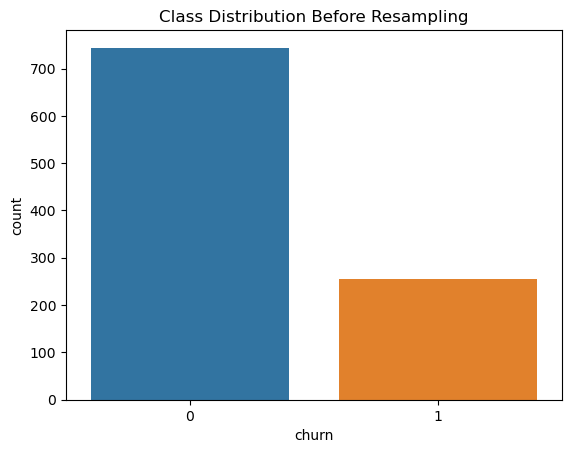

In [58]:
#Resampling - upsampling

sns.countplot('churn', data=df).set_title('Class Distribution Before Resampling')



In [59]:
X_no = X[X.churn == 0]
X_yes = X[X.churn == 1]

In [60]:
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)
print(len(X_yes_upsampled))

744


C:\Users\Gajendra\AppData\Local\Temp\ipykernel_3196\2439130392.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
C:\Users\Gajendra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

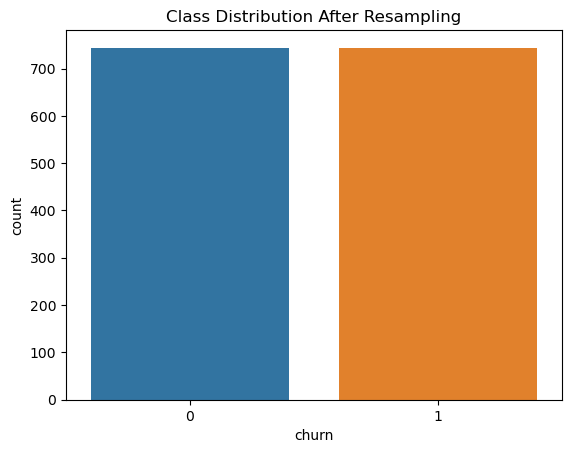

In [61]:
#Combining positive and negative class and checking new distribution

X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('churn', data=X_upsampled).set_title('Class Distribution After Resampling')

# Model Creation and Evaluation

In [64]:
from sklearn.model_selection import train_test_split
X = X_upsampled.drop(['churn'], axis=1) #features (independent variables)
y = X_upsampled['churn'] #target (dependent variable)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

We begin with fitting a ridge classifier to our data. Based on the result, we can choose a better algorithm.

In [66]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

In [67]:
clf_ridge = RidgeClassifier() #create a ridge classifier object
clf_ridge.fit(X_train, y_train) #train the model

RidgeClassifier()

In [68]:
pred = clf_ridge.predict(X_train)
accuracy_score(y_train, pred)

0.7445378151260504

In [69]:
pred_test = clf_ridge.predict(X_test)
accuracy_score(y_test, pred_test)

0.738255033557047

We got a train accuracy of 74% and test accuracy of 73.8% which make the mean accuracy close to 74%. For a better result, let's try random forest.

In [70]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

In [71]:
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [72]:
pred = clf_forest.predict(X_train)
accuracy_score(y_train, pred)

0.9932773109243698

A 99% accuracy looks great but the model might be overfit. Let's check how it performs on the test sample.

In [73]:
pred_test = clf_forest.predict(X_test)
accuracy_score(y_test, pred_test)

0.8926174496644296

To improve the model further, let's do cross validation using GridSearchCV. We will be dividing our data into 5 buckets for cross validation. We will be using all processors, indicated by n_jobs=-1 in the following code.

In [74]:
#Improving the model
from sklearn.model_selection import GridSearchCV

In [75]:
parameters = {'n_estimators':[150,200,250,300], 'max_depth':[15,20,25]}
forest = RandomForestClassifier()
clf = GridSearchCV(estimator=forest, param_grid=parameters, n_jobs=-1, cv=5)

In [76]:
clf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25],
                         'n_estimators': [150, 200, 250, 300]})

In [77]:
clf.best_params_
{'max_depth': 20, 'n_estimators': 150}
clf.best_score_

0.9227058052561408

# Final Output:

We get 90% accuracy with our model. In further score, I will try to improve this accuracy by fine tuning the parameters for gridsearch and by using more advanced models. 